## Setup

In [39]:
# imports
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import os
import time

from kpca.utils import *
from kpca.kernel_pca import KernelPCA
from kpca.data import Loader, half_moons

# ipython
%matplotlib inline 
%load_ext autoreload
%autoreload 2

# seed 
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

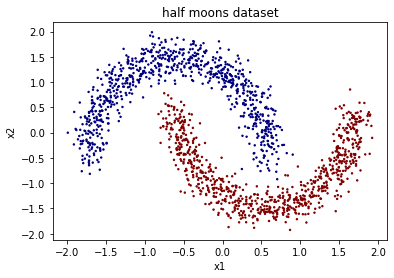

In [40]:
x,labels = half_moons()
plt.scatter(x[:,0],x[:,1],s=2,c=labels,cmap='jet')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('half moons dataset')
plt.show()

## Train

In [41]:
loader = Loader(x,batch_size=64).__iter__()
net = KernelPCA(m=2,n=16,kernel='rbf',sig=0.4)
info = None

In [42]:
info = net.train(loader,etaq=.1,etaw=.1,etal=0.1,n_iter=10000,print_iter=10,info=info)

0/10000: e=-3.7231, t=0.0029
1000/10000: e=0.0134, t=1.4138
2000/10000: e=0.0113, t=2.6563
3000/10000: e=0.0116, t=3.8971
4000/10000: e=0.0122, t=5.1375
5000/10000: e=0.0111, t=6.3799
6000/10000: e=0.0119, t=7.6220
7000/10000: e=0.0118, t=8.8611
8000/10000: e=0.0121, t=10.1006
9000/10000: e=0.0119, t=11.3555


In [43]:
info = net.train(loader,etaq=.01,etaw=.01,etal=0.01,n_iter=10000,print_iter=10,info=info)

0/10000: e=0.0094, t=0.0026
1000/10000: e=0.0129, t=1.3888
2000/10000: e=0.0122, t=2.6309
3000/10000: e=0.0115, t=3.8678
4000/10000: e=0.0135, t=5.1090
5000/10000: e=0.0114, t=6.3471
6000/10000: e=0.0113, t=7.5881
7000/10000: e=0.0094, t=8.8286
8000/10000: e=0.0107, t=10.0683
9000/10000: e=0.0141, t=11.3112


In [44]:
info = net.train(loader,etaq=0.001,etaw=.001,etal=0.001,n_iter=10000,print_iter=10,info=info)

0/10000: e=0.0135, t=0.0015
1000/10000: e=0.0137, t=1.2474
2000/10000: e=0.0124, t=2.4885
3000/10000: e=0.0118, t=3.7302
4000/10000: e=0.0113, t=4.9724
5000/10000: e=0.0129, t=6.2131
6000/10000: e=0.0134, t=7.4516
7000/10000: e=0.0137, t=8.6905
8000/10000: e=0.0109, t=9.9309
9000/10000: e=0.0127, t=11.1708


## Save Figures

In [47]:
MODEL_PATH = './trained-nets/halfmoons.pt'
torch.save(net.state_dict(), MODEL_PATH)

## Training evaluation

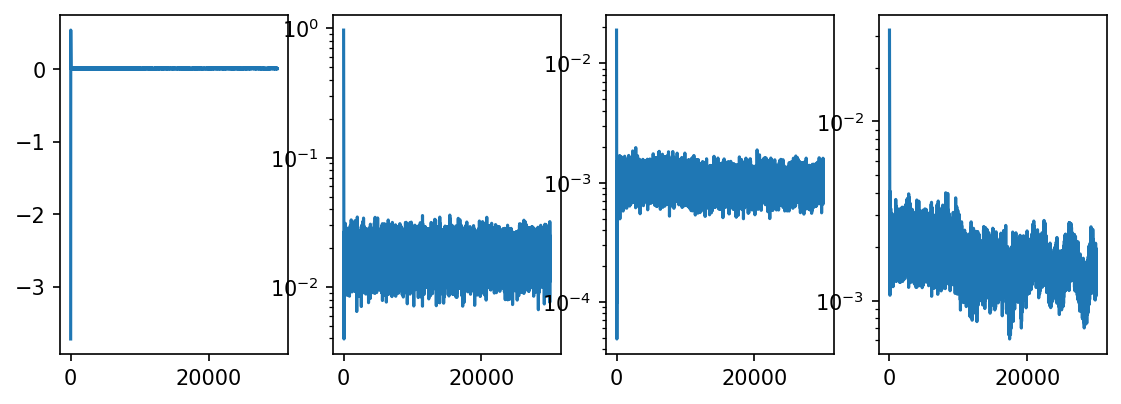

In [48]:
plt.figure(figsize=(9,3),dpi=150)
plt.subplot(141)
plt.plot(info['es'])

plt.subplot(142)
plt.plot(info['gqs'])
plt.yscale('log')

plt.subplot(143)
plt.plot(info['gws'])
plt.yscale('log')

plt.subplot(144)
plt.plot(info['gls'])
plt.yscale('log')

## Visualize the results

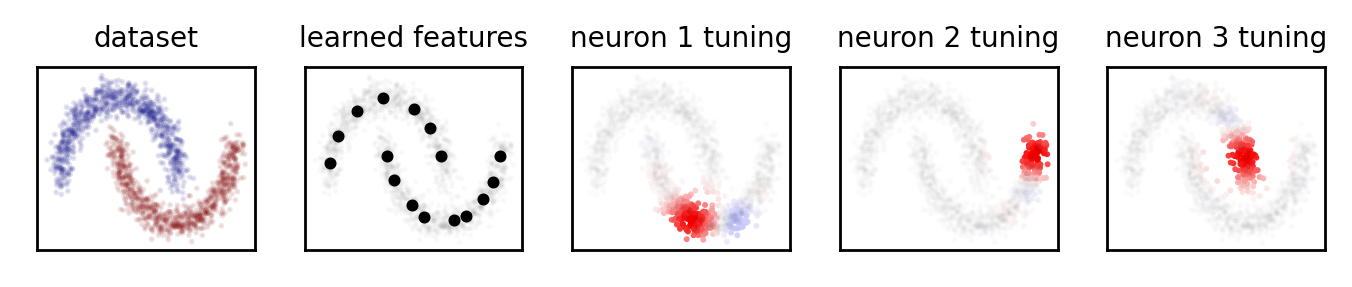

In [49]:
y = net(x)

fontsize=8
plt.figure(figsize=(5.5,1.25),dpi=250)
plt.subplot(151)
plt.scatter(x[:,0],x[:,1],s=0.5,c=labels,cmap='jet',alpha=0.1)

plt.xticks([])
plt.yticks([])
plt.title('dataset', fontsize=fontsize)

plt.subplot(152)
plt.scatter(net.w.detach()[:,0],net.w.detach()[:,1],color='black', s=6, alpha=1.0)
plt.scatter(x.detach()[:,0],x.detach()[:,1],color='black', s=0.5, alpha=0.02)

plt.xticks([])
plt.yticks([])
plt.title('learned features', fontsize=fontsize)

plt.subplot(153)
ix = 0
plt.scatter(x[:,0],x[:,1],s=0.5,c=y[:,ix]/y[:,ix].max(),cmap='bwr',vmin=-1,vmax=1)
plt.scatter(x[:,0],x[:,1],s=0.5,color='black',alpha=0.01)

plt.xticks([])
plt.yticks([])
plt.title('neuron 1 tuning', fontsize=fontsize)

plt.subplot(154)
ix = 1
plt.scatter(x[:,0],x[:,1],s=0.5,c=y[:,ix]/y[:,ix].max(),cmap='bwr',vmin=-1,vmax=1)
plt.scatter(x[:,0],x[:,1],s=0.5,color='black',alpha=0.01)

plt.xticks([])

plt.xticks([])
plt.yticks([])
plt.title('neuron 2 tuning', fontsize=fontsize)

plt.subplot(155)
ix = 2
plt.scatter(x[:,0],x[:,1],s=0.5,c=y[:,ix]/y[:,ix].max(),cmap='bwr',vmin=-1,vmax=1)
plt.scatter(x[:,0],x[:,1],s=0.5,color='black',alpha=0.01)

plt.xticks([])

plt.xticks([])
plt.yticks([])
plt.title('neuron 3 tuning', fontsize=fontsize)

plt.tight_layout()
# plt.savefig('half-moons-overview.pdf')
plt.show()

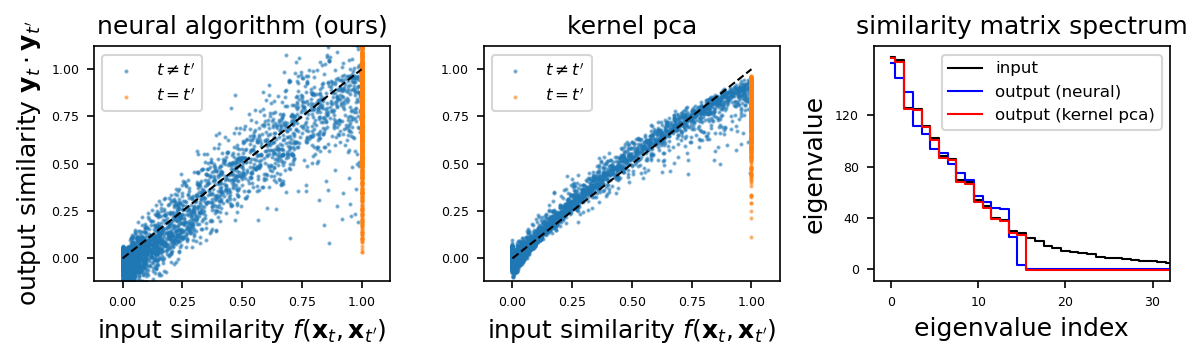

In [50]:
y = net(x)
yy = y @ y.t()
fxx = net.f(x,x)

l,v = fxx.symeig(eigenvectors=True)
z = v[:,-y.shape[1]:] @ l[-y.shape[1]:].sqrt().diag() @ v[:,-y.shape[1]:].t()
zz = z @ z.t()

plt.figure(figsize=(8,2.5),dpi=150)

###########
# alpha = 1
###########
plt.subplot(131)
t = 10000
ixs = torch.randperm(len(offdiag(fxx)))[:t]
plt.scatter(offdiag(fxx).detach().cpu().numpy()[ixs], offdiag(yy).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(fxx).detach().cpu().numpy(), ondiag(yy).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks(torch.linspace(0,1,5),fontsize=6)
plt.xlim(-0.12,1.12)
plt.yticks(torch.linspace(0,1,5),fontsize=6)
plt.ylim(-0.12,1.12)
plt.legend(fontsize=8)

plt.legend(fontsize=8)
plt.xlabel(r"input similarity $f(\mathbf{x}_t,\mathbf{x}_{t'})$",fontsize=12)
plt.ylabel(r"output similarity $\mathbf{y}_t \cdot \mathbf{y}_{t'}$",fontsize=12)
plt.title("neural algorithm (ours)",fontsize=12)

plt.subplot(132)
ixs = torch.randperm(len(offdiag(fxx)))[:t]
plt.scatter(offdiag(fxx).detach().cpu().numpy()[ixs], offdiag(zz).detach().cpu().numpy()[ixs], s=1, alpha=0.5, label=r"$t \neq t'$")
plt.scatter(ondiag(fxx).detach().cpu().numpy(), ondiag(zz).detach().cpu().numpy(), s=1, alpha=0.5, label="$t = t'$")
plt.plot(np.linspace(0,fxx.max().item()), np.linspace(0,fxx.max().item()), color='black', linewidth=1, linestyle='--')

plt.xticks(torch.linspace(0,1,5),fontsize=6)
plt.xlim(-0.12,1.12)
plt.yticks(torch.linspace(0,1,5),fontsize=6)
plt.ylim(-0.12,1.12)
plt.legend(fontsize=8)

plt.xlabel(r"input similarity $f(\mathbf{x}_t,\mathbf{x}_{t'})$",fontsize=12)
# plt.ylabel(r"output similarity $\mathbf{y}_t \cdot \mathbf{y}_{t'}$",fontsize=12)
plt.title("kernel pca",fontsize=12)

plt.subplot(133)
plt.plot(fxx.symeig()[0].flip(0), color='black', linewidth=1, drawstyle='steps-mid', label='input')
plt.plot(yy.symeig()[0].flip(0), color='blue', linewidth=1, drawstyle='steps-mid', label='output (neural)')
plt.plot(zz.symeig()[0].flip(0)-1, color='red', linewidth=1, drawstyle='steps-mid', label='output (kernel pca)')

plt.xticks(torch.linspace(0,30,4),fontsize=6)
plt.xlim(-2,32)
plt.yticks(torch.linspace(0,120,4),fontsize=6)
# plt.ylim(-2,122)
plt.legend(fontsize=8)

plt.xlabel(r"eigenvalue index",fontsize=12)
plt.ylabel(r"eigenvalue",fontsize=12)
plt.title("similarity matrix spectrum",fontsize=12)

plt.tight_layout()

# plt.savefig('half-moons-matching.pdf')
plt.show()